# CART (Classification and Regression Tree) Vs. Linear regression

The purpose of this exercise is to provide an initial sense on how decision Tree compares to a conventional linear regression when the response variable is quantitative.

1.  To begin, construct a regression dataset with known properties:

    ```
    x1 = np.random.normal(size = 300)
    x2 = np.random.normal(size = 300)
    error = 2 * np.random.normal(size = 300)
    y1 = 1 + (2 * x1) + (3 * x2) + error
    ```

    - Apply conventional linear regression using. Then fit a Regression Tree (RT), and print it. 
    - Compare the regression output to the way in which the data were actually generated. 
    - Compare the tree diagram to the way in which the data were actually generated. 
    - Compare how well linear regression and regression Tree fit the data. 
    - What do you conclude about the relative merits of linear regression and RT when the *f(X)* is actually linear and additive ?

2. Now, redefine the two predictors as binary factors and reconstruct the response variable:

    Transform predictors into binary factors
    ```
   x11 = (x1 > 0).astype(int)
   x22 = (x2 > 0).astype(int)
    ```
   Reconstruct the response variable
    ```
   y = 1 + (2 * x11) + (3 * x22) + error
    ```
    - Repeat the comparison. What do you conclude when the *f(X)* is actually a step function and additive ?

3. Under what circumstances is CART likely to perform better than linear regression ? Consider separately the matter of how well the fitted values correspond to the observed values and the implementation of how the predictors are related to the response.


In [1]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

np.random.seed(0)

x1 = np.random.normal(size=300)
x2 = np.random.normal(size=300)
error = 2 * np.random.normal(size=300)

y1 = 1 + 2*x1 + 3*x2 + error

X = np.column_stack([x1, x2])


In [2]:
#1A
lin = LinearRegression()
lin.fit(X, y1)

print("Linear regression coefficients:", lin.coef_)
print("Intercept:", lin.intercept_)


Linear regression coefficients: [1.90602671 3.1716359 ]
Intercept: 0.8350097111565935


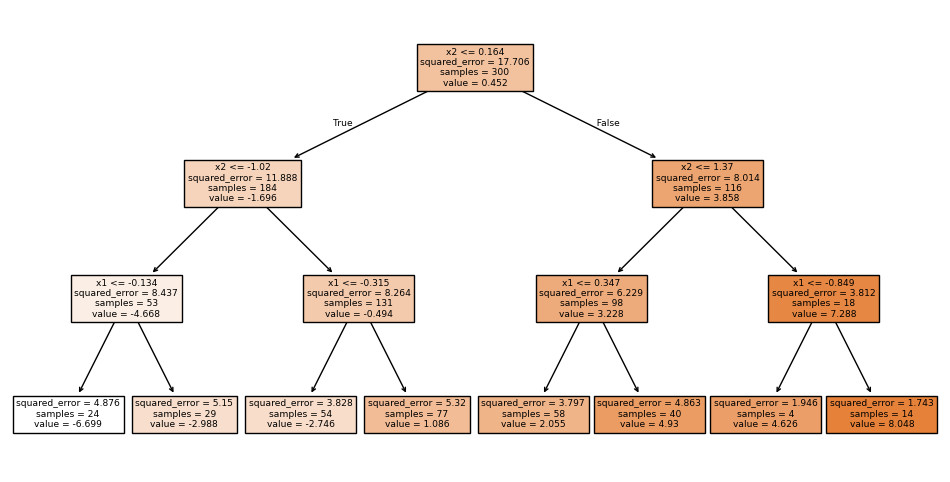

In [3]:
#1B
tree = DecisionTreeRegressor(max_depth=3, random_state=0)
tree.fit(X, y1)

plt.figure(figsize=(12,6))
plot_tree(tree, filled=True, feature_names=["x1", "x2"])
plt.show()


In [4]:
lin_pred = lin.predict(X)
tree_pred = tree.predict(X)

print("Linear Regression MSE:", mean_squared_error(y1, lin_pred))
print("Regression Tree MSE:", mean_squared_error(y1, tree_pred))

Linear Regression MSE: 3.6486245241449082
Regression Tree MSE: 4.43222868602447


In [5]:
#2
x11 = (x1 > 0).astype(int)
x22 = (x2 > 0).astype(int)

y = 1 + 2*x11 + 3*x22 + error
X_bin = np.column_stack([x11, x22])


In [6]:
#2A
lin2 = LinearRegression()
lin2.fit(X_bin, y)

tree2 = DecisionTreeRegressor(max_depth=3, random_state=0)
tree2.fit(X_bin, y)

print("Linear MSE:", mean_squared_error(y, lin2.predict(X_bin)))
print("Tree MSE:", mean_squared_error(y, tree2.predict(X_bin)))


Linear MSE: 3.6646295611871627
Tree MSE: 3.6633299203789496


### 3
## CART (Classification and Regression Trees) outperforms linear regression under several important conditions:

#### CART tends to perform better when:

- The relationship between predictors and the response is nonlinear.Trees naturally capture nonlinear patterns without requiring transformations.

- There are strong interactions between variables.CART automatically models interaction effects through hierarchical splits, whereas linear regression must explicitly include interaction terms.

- The true underlying function has thresholds, step changes, or discontinuities.Trees are piecewise-constant models, making them ideal for detecting sharp boundaries or rule-based structures.

- Predictors are categorical or binary.CART handles categorical inputs natively without the need for dummy encoding.

- Interpretability in terms of decision rules is important.Trees provide transparent, human-readable “if–then” rules.

- Different combinations of predictor values correspond to different outcome regions.CART adapts well to problems where specific feature combinations drive the response.

### Linear Regression tends to perform better when:

- The true relationship is linear and additive.Linear regression is optimal when coefficients combine linearly.

- There is no strong interaction structure in the data.Linear models excel when effects are independent and additive.

- The noise level is moderate and normally distributed.

- The goal is to estimate individual feature effects.Linear regression yields direct coefficient interpretation, unlike CART.

# CART and Gini Index


### Overview and Dataset
In this notebook, we will use a **Decision Tree** classifier to predict the **Tax_Regime** (Exempt, Flat, or Progressive) for various entities (companies/individuals), given their **Country**, **Industry**, **Annual_Income**, and **Number_of_Employees**. 

We will also explore how **Gini impurity** guides the tree's splitting decisions.


## Part 1: Gini Impurity and Manual Split Calculations

### Task - 1 Compute the Root Gini Impurity
    Understand the dataset and find interesting patterns :
        - Calculate the overall Gini of the target variable (Tax_Regime) for the entire dataset
        - Show your formula and numerical steps for first 10-15 rows

### Task 2 – Split by One Feature
    Understand the dataset and find interesting patterns :
        - Choose one feature (e.g., Annual_Income, Employees, or a categorical column) to perform a manual split
            - If numeric (e.g., Annual_Income): pick a threshold (e.g., s < 60000 vs. s >= 60000)
            - If categorical (e.g., Country): pick some subset of countries vs. the others 
        - Separate the dataset into two subsets and compute the Gini impurity for each subset

### Task 3 - Weighted Average Gini After Split


$$

G(t) = p_l \cdot G(t_l) + p_r \cdot G(t_r)

$$
where :
- $  G(t)  $ : Represents the **Gini impurity of the split** at a node $  t  $ .
- $  p_l  $ : Proportion of samples in the **left child** ($  t_l  $ ).
- $  G(t_l)  $ : Gini impurity of the left child.
- $  p_r  $ : Proportion of samples in the **right child** ($  t_r  $ ).
- $  G(t_r)  $ : Gini impurity of the right child.



Compare this to the root Gini impurity and discuss if the reduction is significant

## Part 2: Building and Evaluating a Decision Tree

In [7]:
def gini_impurity(series):
    if series.empty:
        return 0.0
    
    class_counts = series.value_counts()
    total_samples = len(series)
    probabilities = class_counts / total_samples
    gini = 1.0 - np.sum(probabilities**2)
    
    return gini

df = pd.read_csv('tax_data.csv') 
target_column = 'Tax_Regime'
print(f"First 5 rows of data:\n{df.head()}")

root_gini = gini_impurity(df[target_column])

print("\n\n--- Part 1, Task 1: Root Gini Impurity ---")
print(f"Root Gini Impurity: {root_gini:.4f}")
counts = df[target_column].value_counts()
total = len(df)
print(f"Classes: {counts.index.tolist()}")
print(f"Formula: 1 - sum( (Count_i / Total_Samples)^2 )")
print(f"Numerical Steps: 1 - ({counts.values[0]}/{total})^2 - ({counts.values[1]}/{total})^2 - ...")


threshold = 80000

df_left = df[df['Annual_Income'] < threshold]
df_right = df[df['Annual_Income'] >= threshold]

gini_left = gini_impurity(df_left[target_column])
gini_right = gini_impurity(df_right[target_column])

p_left = len(df_left) / len(df)
p_right = len(df_right) / len(df)

weighted_gini = p_left * gini_left + p_right * gini_right

print("\n--- Part 1, Tasks 2 & 3: Weighted Average Gini ---")
print(f"Split: Annual_Income < {threshold}")
print(f"Left Child (N={len(df_left)}), Gini: {gini_left:.4f}, Weight: {p_left:.2f}")
print(f"Right Child (N={len(df_right)}), Gini: {gini_right:.4f}, Weight: {p_right:.2f}")
print(f"Weighted Average Gini: {weighted_gini:.4f}")
print(f"Gini Reduction (Information Gain): {root_gini - weighted_gini:.4f}")




First 5 rows of data:
  Country       Industry  Annual_Income  Employees   Tax_Regime
0     USA           Tech         120000         10  Progressive
1     USA         Retail          30000          2         Flat
2     USA        Finance          45000          3         Flat
3  Canada           Tech          80000          5  Progressive
4  Canada  Manufacturing          35000         15         Flat


--- Part 1, Task 1: Root Gini Impurity ---
Root Gini Impurity: 0.6575
Classes: ['Flat', 'Exempt', 'Progressive']
Formula: 1 - sum( (Count_i / Total_Samples)^2 )
Numerical Steps: 1 - (44/107)^2 - (32/107)^2 - ...

--- Part 1, Tasks 2 & 3: Weighted Average Gini ---
Split: Annual_Income < 80000
Left Child (N=73), Gini: 0.5074, Weight: 0.68
Right Child (N=34), Gini: 0.2076, Weight: 0.32
Weighted Average Gini: 0.4121
Gini Reduction (Information Gain): 0.2454


### Task 1 - Data Preparation
Prepare the data as usual :

    - Do some data analysis (they should be insighful for the problem)
    - For categorical features (Country, Industry), convert them to dummy variables
    - Split off the target
    - Create a 70/30 train-test split

### Task 2 - Decision Tree Classifier with Gini
    - Initialize and fit
    - Tune hyperparameters like max_depth, min_samples_leaf, etc

### Task 3 - Predictions and Evaluation
    - Predict on the test set
    - Calculate and analyse different classification metrics

### Task 4 - Tree Structure
    - Plot and check out how is the tree splitting
    - Compare the top splits with your manual Gini analysis from Part 1
    - Re train with different max_depth values and compare
    - Discuss what are the pro and cons of growing a deep Tree
    - Remember what is the variance of an estimator. Discuss why the variance of a decision tree might be large. Find a way to vizualize it.

X_train shape: (74, 20), X_test shape: (33, 20)

--- Part 2, Task 2: Decision Tree Classifier ---
Model Fitted. Use GridSearchCV for proper hyperparameter tuning.

--- Part 2, Task 3: Predictions and Evaluation ---
Test Accuracy: 0.8182

Classification Report:
              precision    recall  f1-score   support

      Exempt       0.77      1.00      0.87        10
        Flat       0.83      0.71      0.77        14
 Progressive       0.88      0.78      0.82         9

    accuracy                           0.82        33
   macro avg       0.83      0.83      0.82        33
weighted avg       0.83      0.82      0.81        33


--- Part 2, Task 4: Tree Structure and Discussion ---
Top Splits (First few lines of export_text):
|--- Annual_Income <= 87500.00
|   |--- Annual_Income <= 36500.00
|   |   |--- Annual_Income <= 27500.00
|   |   |   |--- class: 0
|   |   |--- Annual_Income >  27500.00
|   |   |   |--- truncated branch of depth 2
|   |--- Annual_Income >  36500.00
|   |   

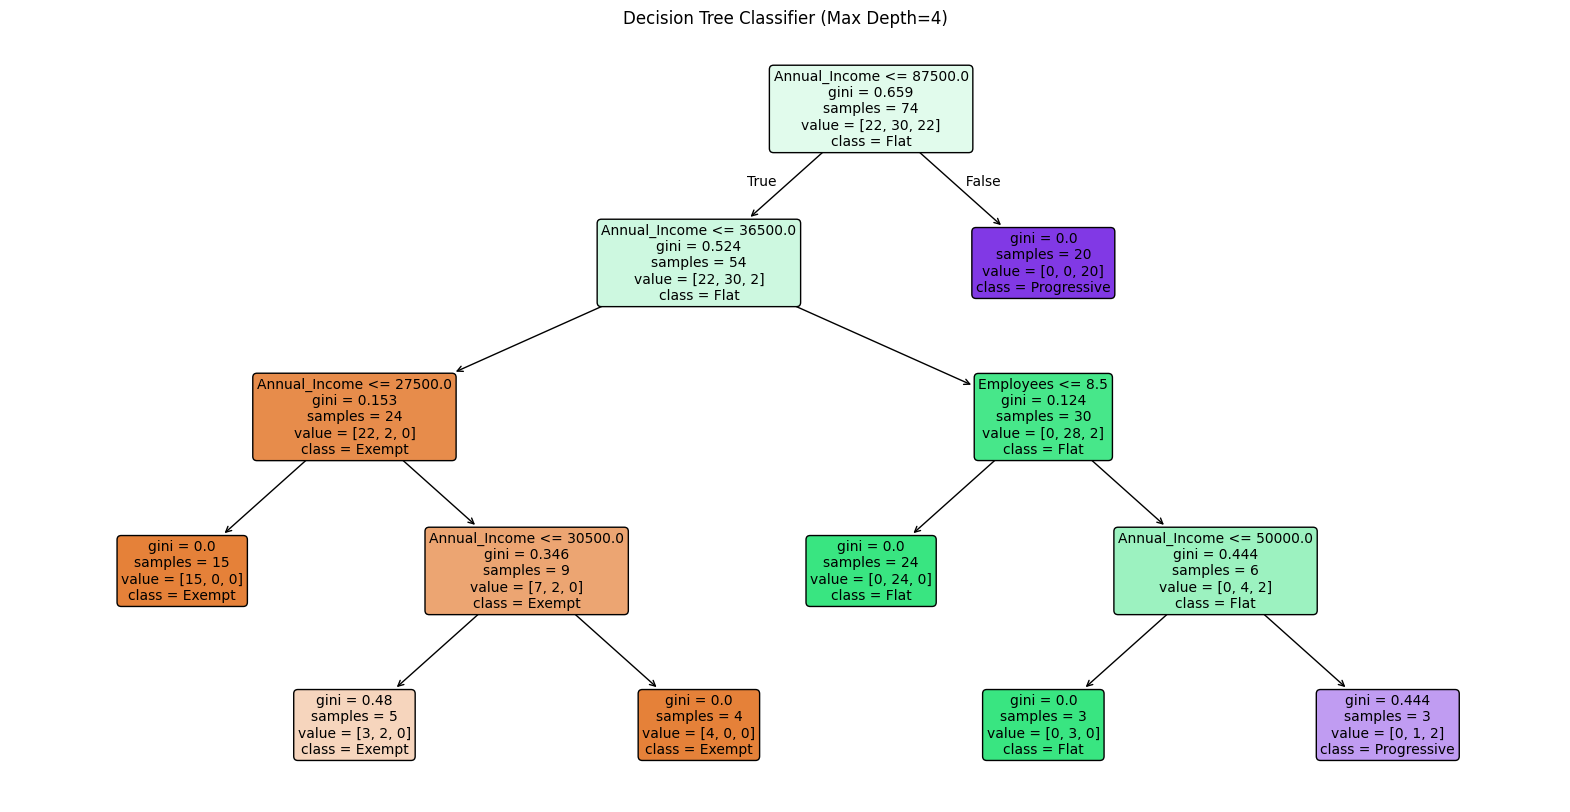

In [8]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, plot_tree, export_text
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import io

try:
    df_prepared = pd.get_dummies(df, columns=['Industry', 'Country'], drop_first=True) 
    
    le = LabelEncoder()
    y_encoded = le.fit_transform(df_prepared[target_column])
    X = df_prepared.drop(columns=[target_column])
    
    X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded)
    
    print(f"X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")
    
except Exception as e:
    print(f"Skipping full data preparation/fitting due to conceptual data: {e}")
    print("Please replace the demonstration DataFrame 'df' with your actual loaded dataset.")
    X_train, X_test, y_train, y_test = None, None, None, None

if X_train is not None:
    print("\n--- Part 2, Task 2: Decision Tree Classifier ---")
    
    dt_model = DecisionTreeClassifier(criterion='gini', max_depth=4, min_samples_leaf=3, random_state=42)
    dt_model.fit(X_train, y_train)
    
    print("Model Fitted. Use GridSearchCV for proper hyperparameter tuning.")

    print("\n--- Part 2, Task 3: Predictions and Evaluation ---")
    y_pred = dt_model.predict(X_test)
    
    print(f"Test Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=le.classes_))

    print("\n--- Part 2, Task 4: Tree Structure and Discussion ---")
    print("Top Splits (First few lines of export_text):")
    print(export_text(dt_model, feature_names=list(X_train.columns), max_depth=2))
    
    plt.figure(figsize=(20, 10))
    plot_tree(dt_model, feature_names=list(X_train.columns), class_names=le.classes_, filled=True, rounded=True, fontsize=10)
    plt.title(f"Decision Tree Classifier (Max Depth=4)")
    plt.show()
